# Classifying Audio Data using AST and Logistic Regression

[ADD BREIF INTRODUCTION TO THE PRIJECT]

## Step 1 : Get the Data from the Recanovo Project

In [ ]:
# Get the Reconvo data from the link https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
# unzip it and put it in the directory: /content/data

! gdown 1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
! tar -xf recanvo.tar.gz
! rm recanvo.tar.gz
! mv recanvo data

Downloading...
From (original): https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
From (redirected): https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm&confirm=t&uuid=087738c7-562e-4fab-bb4d-1469a0b3df69
To: /content/recanvo.tar.gz
100% 1.06G/1.06G [00:11<00:00, 88.7MB/s]


In [ ]:
# Update/install packages to make google colab happy.

! pip install -U scikit-learn
! pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 65.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.0 MB/s eta 0:00:00


Importing necessary packages and libraries

In [ ]:
import functools
from pathlib import Path

import torchaudio.transforms as T
import math


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    log_loss,
    recall_score,
)
from sklearn.model_selection import (
    cross_val_predict,
    StratifiedKFold,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#self note: removed the skopt line below so it'll work, if it gives errors
from skopt import BayesSearchCV
import torch
import torchaudio
from tqdm.notebook import tqdm


def to_prob(metric):
    @functools.wraps(metric)
    def metric_that_takes_prob(y_actual, y_pred, sample_weight=None):
        return metric(y_actual, y_pred.argmax(1), sample_weight=sample_weight)

    return metric_that_takes_prob


metrics = {
    "accuracy": to_prob(accuracy_score),
    "balanced_accuracy": to_prob(balanced_accuracy_score),
    "unweighted_f1": to_prob(functools.partial(f1_score, average="macro")),
    "UAR": to_prob(functools.partial(recall_score, average="macro")),
    "logloss": log_loss,
}

The train test split is made so at least one whole session is in the test set


In [ ]:
# data files [importing the new train test split made by Ale from the link: https://drive.google.com/uc?id=1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4]
! gdown 1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4 -O /content/new_train_test.csv

Downloading...
From: https://drive.google.com/uc?id=1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4
To: /content/new_train_test.csv
100% 523k/523k [00:00<00:00, 89.3MB/s]


In [ ]:
#create a dataframe to hold the data
df = pd.read_csv('/content/new_train_test.csv')
#check labels
display(df.Label.value_counts())

,count
Label,
selftalk,1885
frustrated,1536
delighted,1272
dysregulated,704
social,634
request,419
affectionate,129
yes,123
laughter,93


In [ ]:
#Isolate the data for participant #05
df_P05 = df.loc[df.Participant == "P05"]
#check labels
display(df_P05.Label.value_counts())

,count
Label,
selftalk,286
frustrated,283
delighted,235
dysregulated,116
happy,61
help,24
laughter,13
request,6
hunger,4


In [ ]:
#Drop rows with label count < 30
df_P05_dropped = df_P05[df_P05.Label != 'help']
df_P05_dropped = df_P05_dropped[df_P05.Label != 'laughter']
df_P05_dropped = df_P05_dropped[df_P05.Label != 'request']
df_P05_dropped = df_P05_dropped[df_P05.Label != 'hunger']
display(df_P05_dropped.Label.value_counts())

<ipython-input-7-66317e69b8e9>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_P05_dropped = df_P05_dropped[df_P05.Label != 'laughter']
<ipython-input-7-66317e69b8e9>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_P05_dropped = df_P05_dropped[df_P05.Label != 'request']
<ipython-input-7-66317e69b8e9>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_P05_dropped = df_P05_dropped[df_P05.Label != 'hunger']


,count
Label,
selftalk,286
frustrated,283
delighted,235
dysregulated,116
happy,61


A dataframe is isolated to contain only the training data for participant 05

In [ ]:
#create a dataframe that contains training data for participant 05
train_P05 = df_P05_dropped.loc[df_P05_dropped.is_test == 0]

In [ ]:
#temporary cell: checking the dataframe
#print(train_P05)
print(train_P05.Label.value_counts())

Label
frustrated      208
selftalk        199
delighted       146
dysregulated     74
happy            46
Name: count, dtype: int64


## Reformatting & Looping an Example to Fit the Input Format of AST

The sample rate for our audio files is 44.1k. To fit the input format for AST we need it to be in 16k. We also need to convert .wav files to .flac format (a compressed format), so it's in the correct input format for AST. We will also loop the audio to fit the length required to be an inout to AST.

In the following few cells, we isolate a single .wav file from our dataset and perform the reformatting and looping tasks. We will generalize it later to the entire dataset.

In [ ]:
datadir = Path('/content/ast/data/wav')

target_sample_rate = 16000

#choosing an example
filename1 = train_P05.Filename.iloc[0]
waveform1, sample_rate1 = torchaudio.load(datadir / filename1)
resampler = T.Resample(orig_freq=sample_rate1, new_freq=target_sample_rate)
# Apply the resampler
resampled_waveform1 = resampler(waveform1)

#check shape
print(resampled_waveform1.shape)

In [ ]:
#here we assume the waveform is names "resampled_waveform1"
#make sure to have imported the following
# import math

l = len(resampled_waveform1[0])
multiplier = math.ceil(160200 / l)
#print(multiplier)

# Create a list of the tensor repeated num_repeats times
tensors_list = [resampled_waveform1] * multiplier
# Concatenate them along the new dimension
looped_waveform = torch.cat(tensors_list, dim=1)

# Compute the end index for slicing
end_index = 160200

# Slice the tensor
trimmed_tensor0 = looped_waveform[0][:end_index]
trimmed_tensor = torch.tensor(trimmed_tensor0)
trimmed_looped_waveform1 = trimmed_tensor.unsqueeze(0)

print(trimmed_looped_waveform1.shape)

In [ ]:
#saving the wave form
#target_sample_rate = 16000 #this was run before

torchaudio.save('output_looped1.flac', trimmed_looped_waveform, target_sample_rate)
new_wav , new_sam = torchaudio.load('output_looped1.flac')

print(new_wav.shape)

In [ ]:
#check the sound
IPython.display.Audio('/content/ast/output_looped1.flac')

We will visualize thet features extracted for this example in a later section.

# TEMP EDIT MARGIN 2024 08 27

DELETE THE FOLLOWING THREE CELLS

In [ ]:
##ERASE CELL
#Importing a single wav file from our data

datadir = Path('/content/data/wav')

filename1 = train_P05.Filename.iloc[0]
waveform1, sample_rate1 = torchaudio.load(datadir / filename1)

# sample_rate = 44110
# waveform is a tensor that of shape torch.Size([1, 25181])
# waveform = tensor([[ 4.2725e-04, -1.4038e-03,  2.4719e-03,  ..., -2.4414e-04,
          # 0.0000e+00, -9.1553e-05]])

In [ ]:
##ERASE CELL
# Here we resample the waveform to be 16kHz

import torchaudio.transforms as T

target_sample_rate = 16000  # Target sample rate of 16 kHz
resampler = T.Resample(orig_freq=sample_rate1, new_freq=target_sample_rate)

# Apply the resampler
resampled_waveform1 = resampler(waveform1)

# After the resampling:
# resampled_waveform is of the shape torch.Size([1, 25181])
# resampled_waveform = tensor([[ 0.0004, -0.0005, -0.0006,  ..., -0.0003, -0.0011, -0.0002]])


In [ ]:
##ERASE CELL
# Here we save the resampled waveform as a flac file and import it again

torchaudio.save('output_resampled1.flac', resampled_waveform1, target_sample_rate)
new_wav , new_sam = torchaudio.load('output_resampled1.flac')

# new_sam = 16000
# new_wav is of the shape torch.Size([1, 9136])

In the next section we will import AST and then automate the above process for each datapoint in our dataset, feed them to AST to generate features

Self Note: We may need to loop the audio files to get it to be a certain length. But we will run a trial run without it first.


# Step 2 : Import AST

Here we experiment with extracting features using AST that was introduced in  https://github.com/YuanGongND/ast [ADD A PROPER CITATION]

In [ ]:
#more imports

import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/YuanGongND/ast
    sys.path.append('./ast')
%cd /content/ast/

! pip install timm==0.4.5
! pip install wget
import os, csv, argparse, wget
os.environ['TORCH_HOME'] = '/content/ast/pretrained_models'
if os.path.exists('/content/ast/pretrained_models') == False:
  os.mkdir('/content/ast/pretrained_models')
import timm
from torch.cuda.amp import autocast
import IPython

Running in Colab.
Cloning into 'ast'...
remote: Enumerating objects: 649, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 649 (delta 172), reused 159 (delta 159), pack-reused 440 (from 1)
Receiving objects: 100% (649/649), 2.41 MiB | 16.11 MiB/s, done.
Resolving deltas: 100% (360/360), done.
/content/ast
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manyli

Create AST model and load AudioSet pretrained weights.

In [ ]:
from src.models import ASTModel

# Create a new class that inherits the original ASTModel class
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.v.blocks:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list

def make_features(wav_name, mel_bins, target_length=1024):
    waveform, sr = torchaudio.load(wav_name)
    assert sr == 16000, 'input audio sampling rate must be 16kHz'

    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    return fbank

#REMOVING SINCE WE WILL NOT USE THEIR LABELS
#def load_label(label_csv):
    #with open(label_csv, 'r') as f:
        #reader = csv.reader(f, delimiter=',')
        #lines = list(reader)
    #labels = []
    #ids = []  ## Each label has a unique id such as "/m/068hy"
    #for i1 in range(1, len(lines)):
        #id = lines[i1][1]
        #label = lines[i1][2]
        #ids.append(id)
        #labels.append(label)
    #return labels

# Create an AST model and download the AudioSet pretrained weights
audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
if os.path.exists('/content/ast/pretrained_models/audio_mdl.pth') == False:
  wget.download(audioset_mdl_url, out='/content/ast/pretrained_models/audio_mdl.pth')

# Assume each input spectrogram has 1024 time frames
input_tdim = 1024
checkpoint_path = '/content/ast/pretrained_models/audio_mdl.pth'
# now load the visualization model
ast_mdl = ASTModelVis(label_dim=527, input_tdim=input_tdim, imagenet_pretrain=False, audioset_pretrain=False)
print(f'[*INFO] load checkpoint: {checkpoint_path}')
checkpoint = torch.load(checkpoint_path, map_location='cuda')
audio_model = torch.nn.DataParallel(ast_mdl, device_ids=[0])
audio_model.load_state_dict(checkpoint)
audio_model = audio_model.to(torch.device("cuda:0"))
audio_model.eval()

#REMOVING SINCE WE WILL NOT USE THEIR LABELS
## Load the AudioSet label set
#label_csv = '/content/ast/egs/audioset/data/class_labels_indices.csv'       ## label and indices for audioset data
#labels = load_label(label_csv)

---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212
[*INFO] load checkpoint: /content/ast/pretrained_models/audio_mdl.pth


DataParallel(
  (module): ASTModelVis(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): 

Here we experiment with feature extraction using AST for the example we picked in the previous section

In [ ]:
# Use the make_features function to build spectrograoms and then perform some initial feature extraction process on it
feats1 = make_features('output_resampled1.flac', mel_bins=128)

feats1_data = feats1.expand(1, input_tdim, 128)           # reshape the feature
feats1_data = feats1_data.to(torch.device("cuda:0"))

with torch.no_grad():
  with autocast():
    att_list1 = audio_model.module.forward_visualization(feats1_data)
#REWRITE THE FOLLOWING TO NOT PRINT, BUT OUTPUT THE FEATURES IN THE DESIRED FORMAT
#print(att_list[11])


In [ ]:
# Tempporary Cell
print(feats1.shape)

torch.Size([1024, 128])


We average over a specific dimension to simplify the tensor

In [ ]:
# Tempporary Cell
feats1_mean_axis0 = feats1.mean(dim=0)
print(feats1_mean_axis0.shape)

torch.Size([128])


In [ ]:
# Tempporary Cell
feats1_mean_axis1 = feats1.mean(dim=1)
print(feats1_mean_axis1.shape)

torch.Size([1024])


Perhaps in the long run we will use the feats1 tensor averaged across dim1. So for each data point, we will have 1024 features

## Visualize the features generated by the example

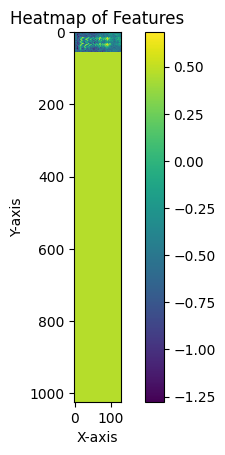

In [ ]:
# Visualize the initial features that were extracted.

# Create a heatmap
plt.imshow(feats1, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.title('Heatmap of Features')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

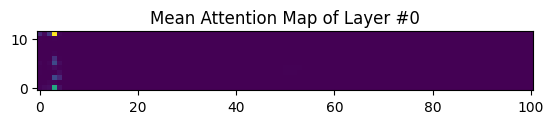

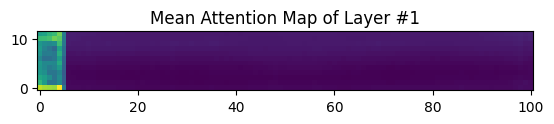

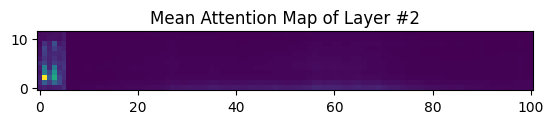

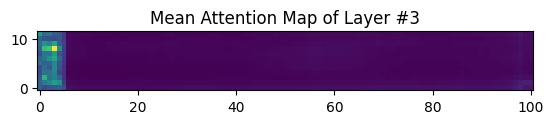

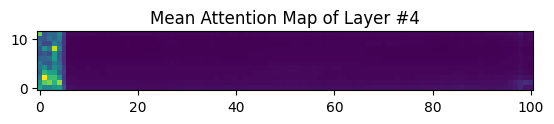

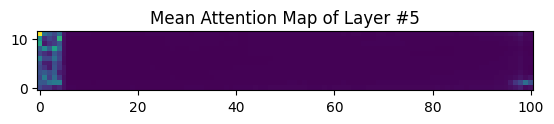

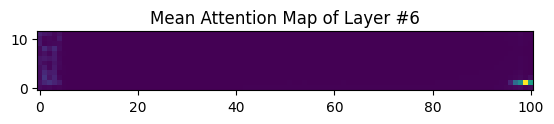

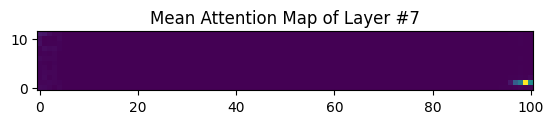

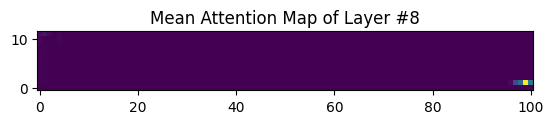

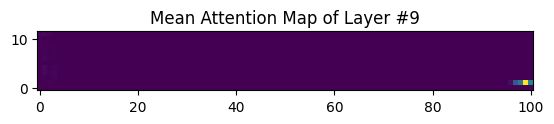

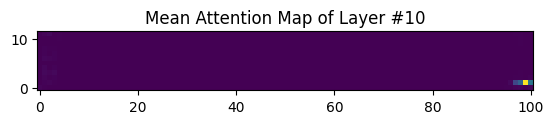

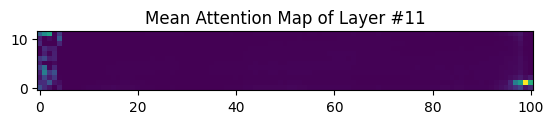

In [ ]:
# Here at att_list is built to hold the results of further layers. And they are visualized as heat maps

with torch.no_grad():
  with autocast():
    att_list1 = audio_model.module.forward_visualization(feats1_data)
for i in range(len(att_list1)):
  att_list1[i] = att_list1[i].data.cpu().numpy()
  att_list1[i] = np.mean(att_list1[i][0], axis=0)
  att_list1[i] = np.mean(att_list1[i][0:2], axis=0)
  att_list1[i] = att_list1[i][2:].reshape(12, 101)
  plt.imshow(att_list1[i], origin='lower')
  plt.title('Mean Attention Map of Layer #{:d}'.format(i))
  plt.show()
  plt.close()

DELETE THE FOLLOWING 4 CELLS AFTER RUNNING ONCE

In [ ]:
# potential feature candidate 2 (1 being feats)
print(att_list1[5].shape)

(12, 101)


In [ ]:
print(att_list1[5])

[[0.00288545 0.00204337 0.00198695 ... 0.00116765 0.00040526 0.00063775]
 [0.00364099 0.00352812 0.00481339 ... 0.00278701 0.00465114 0.00312485]
 [0.0028143  0.00521764 0.00249129 ... 0.00071957 0.00041222 0.00066948]
 ...
 [0.00764903 0.00090631 0.00179434 ... 0.00034722 0.00020413 0.00016807]
 [0.00648265 0.00172264 0.00267594 ... 0.0004606  0.000245   0.00028681]
 [0.0128057  0.0047717  0.00377587 ... 0.00081737 0.00032651 0.00029336]]


In [ ]:
att_5_trial = torch.from_numpy(att_list1[5])
print(att_5_trial.shape)

torch.Size([12, 101])


In [ ]:
att_list5_flat = torch.flatten(att_5_trial)
print(att_list5_flat.shape)

torch.Size([1212])


Here we try the same visualization for a different example after looping the audio

In [ ]:
#choosing another example
filename2 = train_P05.Filename.iloc[5]
waveform2, sample_rate2 = torchaudio.load(datadir / filename2)
resampler = T.Resample(orig_freq=sample_rate2, new_freq=target_sample_rate)
# Apply the resampler
resampled_waveform2 = resampler(waveform2)

l = len(resampled_waveform2[0]) #take the length of the waveform
multiplier = math.ceil(160200 / l) #create a multiplier
tensors_list = [resampled_waveform2] * multiplier  # Create a list of the tensor repeated num_repeats times
looped_waveform = torch.cat(tensors_list, dim=1) # Concatenate them along the new dimension
  #Slice
end_index = 160200 #the length that fit the input format for AST
trimmed_tensor0 = looped_waveform[0][:end_index] #cutting off the tail
trimmed_tensor = torch.tensor(trimmed_tensor0)
trimmed_looped_waveform2 = trimmed_tensor.unsqueeze(0)
  #Save flac file
torchaudio.save('output_looped2.flac', trimmed_looped_waveform2, target_sample_rate)
#new_wav , new_sam = torchaudio.load('output_looped.flac') #not needed


In [ ]:
#check the sound
IPython.display.Audio('/content/ast/output_looped1.flac')

In [ ]:
# Use the make_features function to build spectrograoms and then perform some initial feature extraction process on it
feats2 = make_features('output_looped2.flac', mel_bins=128)

feats2_data = feats2.expand(1, input_tdim, 128)           # reshape the feature
feats2_data = feats2_data.to(torch.device("cuda:0"))

with torch.no_grad():
  with autocast():
    att_list2 = audio_model.module.forward_visualization(feats2_data)


In [ ]:
# Visualize the initial features that were extracted.

# Create a heatmap
plt.imshow(feats2, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.title('Heatmap of Features')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

In [ ]:
# Here at att_list is built to hold the results of further layers. And they are visualized as heat maps

with torch.no_grad():
  with autocast():
    att_list2 = audio_model.module.forward_visualization(feats2_data)
for i in range(len(att_list2)):
  att_list2[i] = att_list2[i].data.cpu().numpy()
  att_list2[i] = np.mean(att_list2[i][0], axis=0)
  att_list2[i] = np.mean(att_list2[i][0:2], axis=0)
  att_list2[i] = att_list2[i][2:].reshape(12, 101)
  plt.imshow(att_list2[i], origin='lower')
  plt.title('Mean Attention Map of Layer #{:d}'.format(i))
  plt.show()
  plt.close()

# Step 3 : Extracting Features for All the Data Points in the Training Data for Participant 05



In [ ]:
# these were run earlier
# datadir = Path('/content/data/wav')
# import torchaudio.transforms as T
# target_sample_rate = 16000  # Target sample rate of 16 kHz

feats_list = [] # feature list 0 # Check if this should gather feats_data instead
feats_2_list = [] # feature list 1
Att1_list = [] # feature list 2 ###
Att5_list = [] # feature list 3 ### commented out for now, since we have to figure out a feasible size compression tactic first

for filename in train_P05.Filename:
  waveform, sample_rate = torchaudio.load(datadir / filename)
  #resample
  resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
  resampled_waveform = resampler(waveform) # Apply the resampler
  #loop
  l = len(resampled_waveform[0]) #take the length of the waveform
  multiplier = math.ceil(160200 / l) #create a multiplier
  tensors_list = [resampled_waveform] * multiplier  # Create a list of the tensor repeated num_repeats times
  looped_waveform = torch.cat(tensors_list, dim=1) # Concatenate them along the new dimension
  #Slice
  end_index = 160200 #the length that fit the input format for AST
  trimmed_tensor0 = looped_waveform[0][:end_index] #cutting off the tail
  trimmed_tensor = torch.tensor(trimmed_tensor0)
  trimmed_looped_waveform = trimmed_tensor.unsqueeze(0)
  #Save flac file
  torchaudio.save('output_looped.flac', trimmed_looped_waveform, target_sample_rate)
  #new_wav , new_sam = torchaudio.load('output_looped.flac') #not needed

  # use AST model to make features. Make sure the cell containing the model has been run
  feats = make_features('output_looped.flac', mel_bins=128)

  feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
  feats_data = feats_data.to(torch.device("cuda:0"))

  #make the att_list that contains the results of later layers 1 through 11. We may choose any of these as our features
  with torch.no_grad():
    with autocast():
      att_list = audio_model.module.forward_visualization(feats_data)
  for i in range(len(att_list)):
    att_list[i] = att_list[i].data.cpu().numpy()
    att_list[i] = np.mean(att_list[i][0], axis=0)
    att_list[i] = np.mean(att_list[i][0:2], axis=0)
    att_list[i] = att_list[i][2:].reshape(12, 101)

  att_list1 = torch.from_numpy(att_list[1]) #reshape to get a tensor
  att_list5 = torch.from_numpy(att_list[5]) #reshape to get a tensor

  #turn the feats tensor into 1 dimensional arrays in two different ways
  feats_mean_axis1 = feats.mean(dim=1) #Averaging across the shorter direction so we get a 1024 long array instead of 1024 by 128 tensor
  feats_mean_axis0 = feats.mean(dim=0)
  att_list1_flat = torch.flatten(att_list1) #att_list[1] is two dimensional. here we concatenate rows to get a one dimensional array of length 1212
  att_list5_flat = torch.flatten(att_list5) #same as above

  #gather the features into previously made lists
  feats_list.append(feats_mean_axis1)
  feats_2_list.append(feats_mean_axis0)
  Att1_list.append(att_list1_flat) ###
  Att5_list.append(att_list5_flat) ###

X = torch.stack(feats_list).detach()
X_1 = torch.stack(feats_2_list).detach()
X_2 = torch.stack(Att1_list).detach() ###
X_3 = torch.stack(Att5_list).detach() ###

labels = train_P05.Label.unique()
y = torch.zeros(len(train_P05), dtype=torch.int)
for idx, label in enumerate(labels):
    y[(train_P05.Label == label).values] = idx
print(X.shape, y.shape)


torch.Size([673, 1024]) torch.Size([673])


In [ ]:
print(X_1.shape, X_2.shape, X_3.shape)

torch.Size([673, 128]) torch.Size([673, 1212]) torch.Size([673, 1212])


# Step 4 : Use Logistic Regression for the Classification

Here we check accuracy for the four types of features we gathered

In [ ]:
# seeing which feature makes the most sense
# checking accuracy for feature set 0 : X
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X.reshape(len(X), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict([('logisticregression__C', 0.0060946674821578594)])
Best accuracy: 0.34916593503072874


In [ ]:
# seeing which feature makes the most sense
# checking accuracy for feature set 1 : X_1
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X_1.reshape(len(X_1), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict([('logisticregression__C', 0.3735807453955014)])
Best accuracy: 0.5736611062335382


In [ ]:
# seeing which feature makes the most sense
# checking accuracy for feature set 2 : X_2
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X_2.reshape(len(X_2), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict([('logisticregression__C', 0.06329537160779325)])
Best accuracy: 0.5454126426690078


In [ ]:
# seeing which feature makes the most sense
# checking accuracy for feature set 3 : X_3
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X_3.reshape(len(X_3), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict([('logisticregression__C', 0.0061887314073235025)])
Best accuracy: 0.5320676031606674


Run Logistic Regression and Check Accuracy

In [ ]:
# Some possible sample weights for training and/or metrics.
# session_weight weights each sample based on sessions, so
# that the total weight of observations in each sesion is
# constant. On top of that, session_and_label_weight assigns
# a label to each weight, which is multiplied by the sesion weight,
# in such a way to make the sum of the weights constant by label.
session_weight = (
    (1 / train_P05.Session.value_counts())
    .clip(None, 0.1)
    .loc[train_P05.Session]
).values
session_and_label_weight = (
    1
    / pd.Series(session_weight, train_P05.index)
    .groupby(train_P05.Label)
    .sum()
).loc[train_P05.Label].values * session_weight

Running the experiment for feature X

In [ ]:
# Generate out-of-sample predictions using a logistic
# regression model, with the parameter determined by
# the optimization above.
#
# We compute various metrics, using various weightings
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)
oos_pred_prob = cross_val_predict(
    est,
    X.reshape(len(X), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    params={"logisticregression__sample_weight": session_weight},
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

,no_weight
accuracy,0.305
balanced_accuracy,0.253
unweighted_f1,0.229
UAR,0.253
logloss,1.561


,session_weight
accuracy,0.352
balanced_accuracy,0.261
unweighted_f1,0.253
UAR,0.261
logloss,1.454


,session_and_label_weight
accuracy,0.261
balanced_accuracy,0.261
unweighted_f1,0.226
UAR,0.261
logloss,1.757


In [ ]:
# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y, oos_pred), columns=labels, index=labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

In [ ]:
# Create a heatmap
plt.imshow(conf_matrix_df, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.title('Confusion Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

Running the experiment for feature X_1

In [ ]:
# Generate out-of-sample predictions using a logistic
# regression model, with the parameter determined by
# the optimization above.
#
# We compute various metrics, using various weightings
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)
oos_pred_prob = cross_val_predict(
    est,
    X_1.reshape(len(X_1), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    params={"logisticregression__sample_weight": session_weight},
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

,no_weight
accuracy,0.501
balanced_accuracy,0.361
unweighted_f1,0.337
UAR,0.361
logloss,1.299


,session_weight
accuracy,0.481
balanced_accuracy,0.340
unweighted_f1,0.329
UAR,0.340
logloss,1.236


,session_and_label_weight
accuracy,0.340
balanced_accuracy,0.340
unweighted_f1,0.280
UAR,0.340
logloss,1.522


In [ ]:
# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y, oos_pred), columns=labels, index=labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,happy,frustrated,dysregulated,selftalk,delighted
actual_label,,,,,
happy,5,1,0,32,8
frustrated,0,131,0,64,13
dysregulated,3,22,0,40,9
selftalk,0,13,0,171,15
delighted,1,22,0,93,30


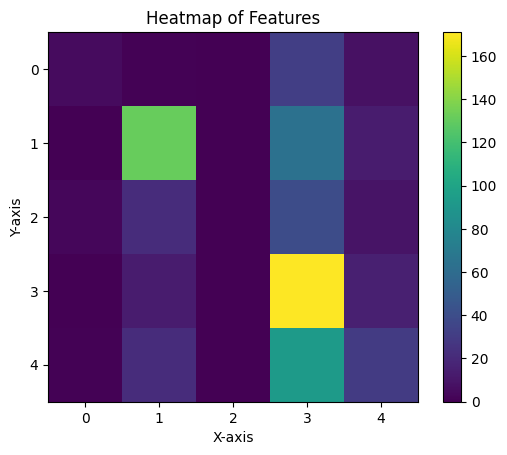

In [ ]:
# Create a heatmap
plt.imshow(conf_matrix_df, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.title('Confusion Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

Running the Experiment for feature X_2

In [ ]:
# Generate out-of-sample predictions using a logistic
# regression model, with the parameter determined by
# the optimization above.
#
# We compute various metrics, using various weightings
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)
oos_pred_prob = cross_val_predict(
    est,
    X_2.reshape(len(X_2), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    params={"logisticregression__sample_weight": session_weight},
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

,no_weight
accuracy,0.328
balanced_accuracy,0.238
unweighted_f1,0.194
UAR,0.238
logloss,1.476


,session_weight
accuracy,0.392
balanced_accuracy,0.243
unweighted_f1,0.216
UAR,0.243
logloss,1.375


,session_and_label_weight
accuracy,0.243
balanced_accuracy,0.243
unweighted_f1,0.172
UAR,0.243
logloss,1.697


In [ ]:
# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y, oos_pred), columns=labels, index=labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,happy,frustrated,dysregulated,selftalk,delighted
actual_label,,,,,
happy,2,0,0,31,13
frustrated,0,25,0,152,31
dysregulated,1,3,0,65,5
selftalk,0,3,0,165,31
delighted,0,4,0,113,29


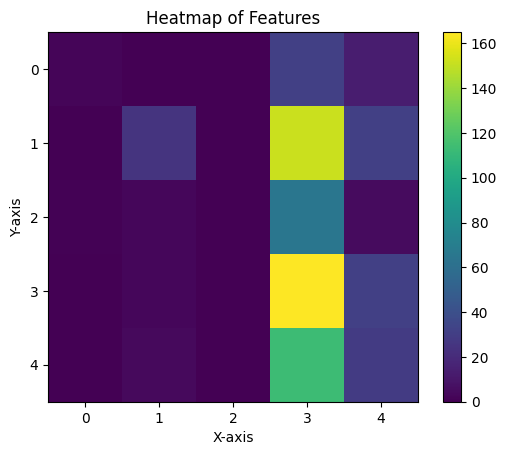

In [ ]:
# Create a heatmap
plt.imshow(conf_matrix_df, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.title('Confusion Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

Running the Experiment for X_3

In [ ]:
# Generate out-of-sample predictions using a logistic
# regression model, with the parameter determined by
# the optimization above.
#
# We compute various metrics, using various weightings
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)
oos_pred_prob = cross_val_predict(
    est,
    X_3.reshape(len(X_3), -1), #why was this reshaping done?
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    params={"logisticregression__sample_weight": session_weight},
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

,no_weight
accuracy,0.299
balanced_accuracy,0.209
unweighted_f1,0.132
UAR,0.209
logloss,1.482


,session_weight
accuracy,0.364
balanced_accuracy,0.207
unweighted_f1,0.148
UAR,0.207
logloss,1.384


,session_and_label_weight
accuracy,0.207
balanced_accuracy,0.207
unweighted_f1,0.107
UAR,0.207
logloss,1.712


In [ ]:
# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y, oos_pred), columns=labels, index=labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,happy,frustrated,dysregulated,selftalk,delighted
actual_label,,,,,
happy,0,0,0,45,1
frustrated,0,4,0,157,47
dysregulated,0,1,0,70,3
selftalk,0,2,0,178,19
delighted,0,2,0,125,19


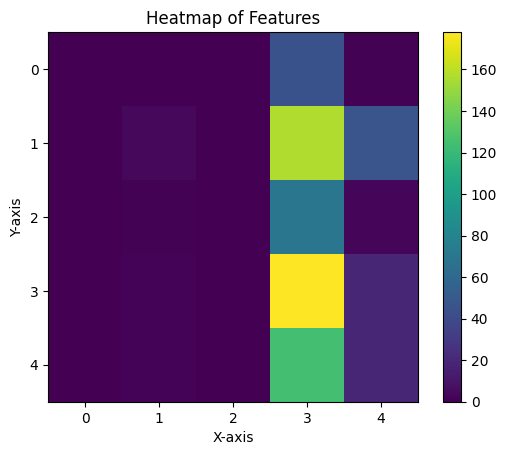

In [ ]:
# Create a heatmap
plt.imshow(conf_matrix_df, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.title('Confusion Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

# Conclusions

[FILL]
